In [1]:
 %run /Desktop/Share/CUDA_DEVICE_setup.py -n 1

using GPU ID:1,



In [2]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [3]:
#%config Completer.use_jedi = False

import sys
sys.path.append('..')


    
import tensorflow as tf    
from collections import defaultdict
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from tndm.data import DataManager
from tndm import LFADS
from tndm.runtime import Runtime
from typing import Dict, Any
from sklearn.linear_model import Ridge

from plotting import *

In [4]:
# read the data/disk/scratch/cole/Chewie_CO_FF_2016-10-07_pos_M1_spikes/test_data/
spike_data_dir = "Chewie_CO_FF_2016-10-07_pos_M1_spikes/"

data_dir = os.path.join( spike_data_dir )

dataset, settings = DataManager.load_dataset(
    directory=data_dir,
    filename='dataset.h5')

#train
neural_data = dataset['train_data'].astype('float')
behavioural_data = dataset['train_behaviours'].astype('float')

# valid
valid_neural_data = dataset['valid_data'].astype('float')
valid_behavioural_data = dataset['valid_behaviours'].astype('float')

# test
test_neural_data = dataset['test_data'].astype('float')
test_behavioural_data = dataset['test_behaviours'].astype('float')

# get dataset, to train by myself
# with_behaviour = False for lfads
# target = input for reconstruction

In [5]:
(x_train, y_train), (x_val, y_val) = Runtime.clean_datasets(
            train_dataset=(neural_data, behavioural_data), 
            val_dataset=(valid_neural_data, valid_behavioural_data), 
            with_behaviour=False
            )

In [6]:
x_test = test_neural_data
y_test = test_behavioural_data

In [7]:
def print_data_shape(data):
    if data is not None:
        print(data.shape)
    else:
        print("None")

In [8]:
print_data_shape(x_train)
print_data_shape(y_train)
print_data_shape(x_val)
print_data_shape(y_val)
print_data_shape(x_test)
print_data_shape(y_test)

(136, 73, 70)
None
(17, 73, 70)
None
(17, 73, 70)
(17, 73, 2)


# Quantize data first
## the input and last layer will remain ap<16,6> precision

In [9]:
AP_BITS = 16
AP_INTS = 6

In [10]:
# ususal quantize
from qkeras import QActivation
ACTIVATION_BITS = "quantized_bits(16,5,alpha=1)".format(AP_BITS, AP_INTS-1)

In [11]:
total_data = [x_train, y_train, x_val, y_val, x_test, y_test]

for index, d in enumerate(total_data):
    print("index: ", index)
    if d is None:
        print("None")
    else:                
        print("before quantization min/max: {} / {}".format(d.min(), d.max()))
        q_d = QActivation(ACTIVATION_BITS)(d)
        q_d_numpy = q_d.numpy()
        print("after quantization min/max: {} / {}".format(q_d_numpy.min(), q_d_numpy.max()))
        total_data[index] = q_d_numpy
    
[x_train, y_train, x_val, y_val, x_test, y_test] = total_data    

index:  0
before quantization min/max: 0.0 / 3.0
after quantization min/max: 0.0 / 3.0
index:  1
None
index:  2
before quantization min/max: 0.0 / 3.0
after quantization min/max: 0.0 / 3.0
index:  3
None
index:  4
before quantization min/max: 0.0 / 3.0
after quantization min/max: 0.0 / 3.0
index:  5
before quantization min/max: -37.970200467724624 / 8.219350904936888
after quantization min/max: -32.0 / 8.2197265625


# build model

In [12]:
# model parameters

# l2 regulariser for the recurrent decoder weights
l2_reg = .1
#initial_neural_weight = 1.0 # weight of neural nll
#initial_behaviour_weight = .2 # weight of behaviour loss
#lambda_q = 100.0
#update_rate = .0005
dropout = .15
#seed = 0
#GRU_pre_activation = False
#var_min = 0.0001
#prior_variance = 1
threshold_poisson_log_firing_rate = 100.

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-2,
    beta_1=0.9, 
    beta_2=0.999,
    epsilon=1e-08)

layers_settings=defaultdict(lambda: dict(
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1.0, mode='fan_in', distribution='normal'),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)
))

layers_settings['decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))    

In [13]:
layers_settings['encoder']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x7f9a3cfe4940>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x7f9a3cfe4fd0>}

In [14]:
layers_settings['decoder']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x7f9a3cf95df0>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x7f9a3cf95f70>,
 'recurrent_regularizer': <keras.regularizers.L2 at 0x7f9a3cf70040>,
 'original_cell': False}

In [15]:
layers_settings['dense_mean']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x7f9a3cfe4cd0>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x7f9a3cfe4370>}

# input for decoder GRU

In [16]:
# Assuming inputs are zero and everything comes from the GRU

In [17]:
inputs2decoder_train = tf.stack([tf.zeros_like(x_train)[:, :, -1]
            for i in range(64)], axis=-1)
inputs2decoder_val = tf.stack([tf.zeros_like(x_val)[:, :, -1]
            for i in range(64)], axis=-1)

In [18]:
inputs2decoder_train = np.array(inputs2decoder_train)
inputs2decoder_val = np.array(inputs2decoder_val)

In [19]:
print(inputs2decoder_train.max())
print(inputs2decoder_val.max())

0.0
0.0


In [20]:
print(inputs2decoder_train.shape)
print(inputs2decoder_val.shape)

(136, 73, 64)
(17, 73, 64)


In [21]:
from qkeras import QGRU, QDense
from tensorflow.keras.layers import Input, Dropout,Bidirectional
from tensorflow.keras import Model

## function to build the model

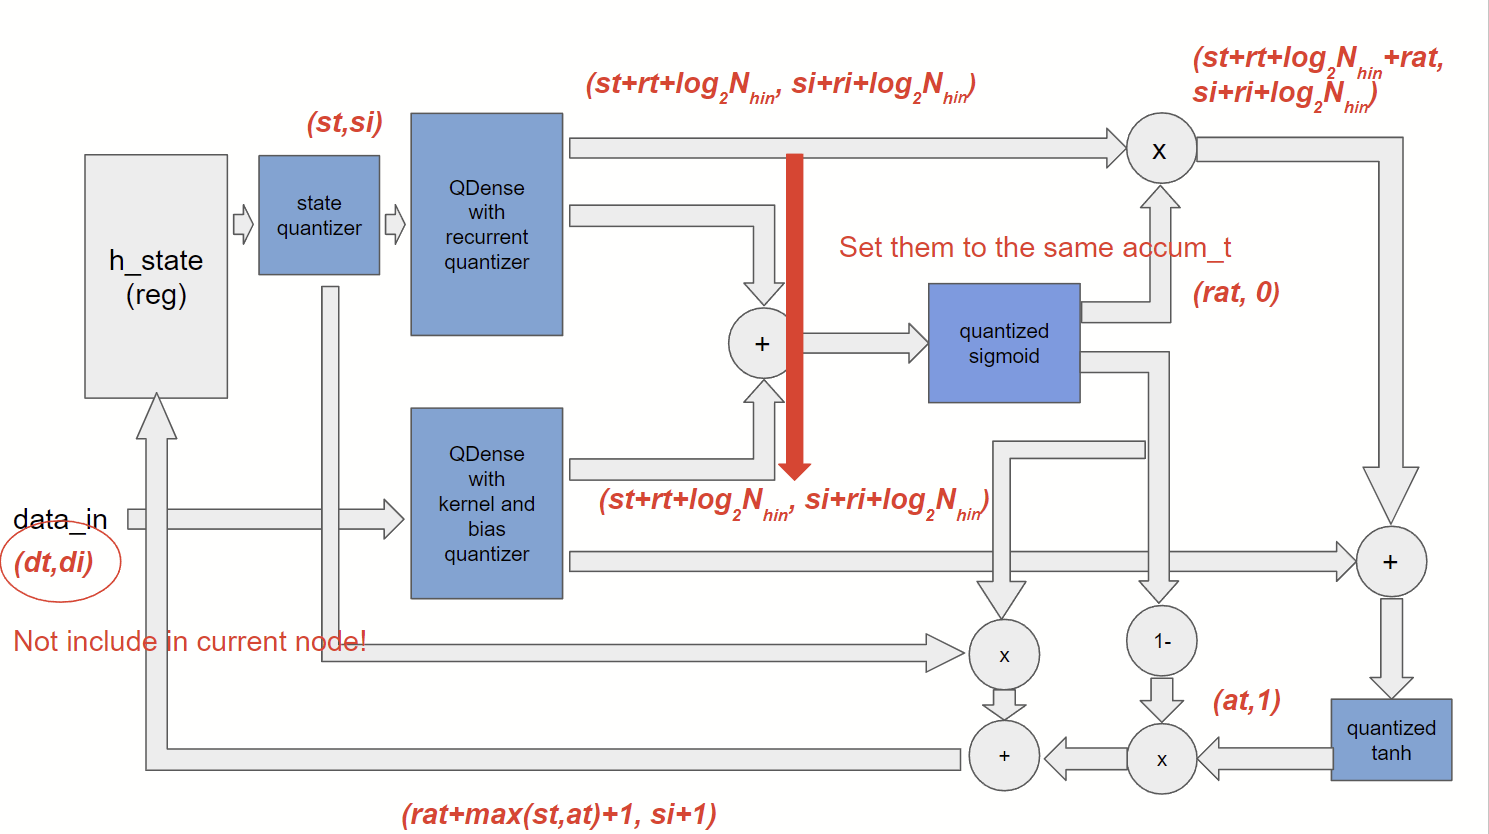

## the ACCUM bits in QGRU is based on the state quantizer, so the previous act_quan precision should be less than it
## here set the state quantizer same as the act_quan

In [22]:
def create_model(act_total_bits=8, act_int_bits=2, 
                 qgru_total_bits=8, qgru_int_bits=2, qgru_sigmoid_bits=8, qgru_tanh_bits=8, drop=0.05
                ):
    
    # keras tuner params:
    
    act_quan = "quantized_bits({},{},alpha=1)".format(act_total_bits, act_int_bits)
    quan = "quantized_bits({},{},alpha=1)".format(qgru_total_bits, qgru_int_bits)
    q_sigmoid = "quantized_sigmoid({})".format(qgru_sigmoid_bits)
    q_tanh = "quantized_tanh({})".format(qgru_tanh_bits)
       
    # input layer
    inputLayer =  Input(shape=(73, 70))    
    # no need to quantize the input layer, already qunaitzed  
    
    x = Dropout(drop, name = 'initial_dropout')(inputLayer)
    
    # encoder
    forward_layer = QGRU(
            64, 
            activation=q_tanh,
            recurrent_activation=q_sigmoid,
            kernel_quantizer=quan,
            recurrent_quantizer=quan,
            bias_quantizer=quan,
            state_quantizer=act_quan,
            kernel_regularizer=layers_settings['encoder']['kernel_regularizer'],
            kernel_initializer=layers_settings['encoder']['kernel_initializer'],
            reset_after = True,
           time_major=False, name="EncoderGRUForward", return_state=True)
    
    backward_layer = QGRU(
            64, 
            activation=q_tanh,
            recurrent_activation=q_sigmoid,
            kernel_quantizer=quan,
            recurrent_quantizer=quan,
            bias_quantizer=quan,
            state_quantizer=act_quan,
            kernel_regularizer=layers_settings['encoder']['kernel_regularizer'],
            kernel_initializer=layers_settings['encoder']['kernel_initializer'],
            reset_after = True,
            time_major=False, name="EncoderGRUBackward", return_state=True, go_backwards=True)
        
        
    x = Bidirectional(
        forward_layer, 
        backward_layer=backward_layer,
        merge_mode='concat', 
        name = 'Encoder_BidirectionalGRU'
        )(x)[0]    
    x = QActivation(act_quan, name = "active_bits0")(x)
    
    x = Dropout(drop, name = 'postencoder_dropout')(x)
    
    # latent space, no mean and var 
    x = QDense(64, 
               kernel_quantizer=quan,
                bias_quantizer=quan,
               kernel_regularizer=layers_settings['dense_mean']['kernel_regularizer'],
               kernel_initializer=layers_settings['dense_mean']['kernel_initializer'],
               name='dense_latent'
              )(x)
    x = QActivation(act_quan, name = "active_bits1")(x)
    
    # decoder
    input_decoder = Input(shape=(73, 64))
    
    x = QGRU(                        
            64, 
            activation=q_tanh,
            recurrent_activation=q_sigmoid,
            kernel_quantizer=quan,
            recurrent_quantizer=quan,
            bias_quantizer=quan,
            state_quantizer=act_quan,
            kernel_regularizer=layers_settings['decoder']['kernel_regularizer'],
            kernel_initializer=layers_settings['decoder']['kernel_initializer'],
            reset_after = True,
            return_sequences=True, time_major=False, name='DecoderGRU'
    )(input_decoder, initial_state = x)
    x = QActivation(act_quan, name = "active_bits2")(x)
    
    x = Dropout(drop, name = 'postdecoder_dropout')(x)
    z = QDense(4, 
            kernel_quantizer=quan,
            bias_quantizer=quan,
            use_bias=False, 
            kernel_regularizer=layers_settings['dense']['kernel_regularizer'],
            kernel_initializer=layers_settings['dense']['kernel_initializer'],
            name="dense"
            )(x)
    z = QActivation(act_quan, name = "active_bits3")(z)
    
    log_f = QDense(70, 
            kernel_quantizer=quan,
            bias_quantizer=quan,
            use_bias=False, 
            kernel_regularizer=layers_settings['nerual_dense']['kernel_regularizer'],
            kernel_initializer=layers_settings['nerual_dense']['kernel_initializer'],
                   name='nerual_dense')(z)
    
    z = QActivation(act_quan, name = "active_bits4")(log_f)

    model = Model(inputs = [inputLayer,input_decoder], outputs =z)
    
    return model

# loss: poisson_loglike_loss

In [23]:
timestep = 0.01

def poisson_loglike_loss(y_true, y_pred):    
    # POISSON LOG-LIKELIHOOD
    # clip the y_pred first
    y_pred = tf.clip_by_value(y_pred, 
                                     clip_value_min=-threshold_poisson_log_firing_rate,
                                     clip_value_max=threshold_poisson_log_firing_rate
                             )
    targets = tf.cast(y_true, dtype=tf.float32)
    logrates = tf.cast(tf.math.log(timestep) + y_pred, tf.float32)  # Timestep
    return tf.reduce_sum(tf.nn.log_poisson_loss(
        targets=targets,
        log_input=logrates, compute_full_loss=True
    ))

# train a 16bits model
## no regulization loss

In [24]:
model = create_model(act_total_bits=16, 
                     act_int_bits=5, 
                 qgru_total_bits=16, 
                     qgru_int_bits=5, 
                     qgru_sigmoid_bits=16, 
                     qgru_tanh_bits=16, 
                     drop=dropout, 
                    )

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['input_1[0][0]']                
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                              

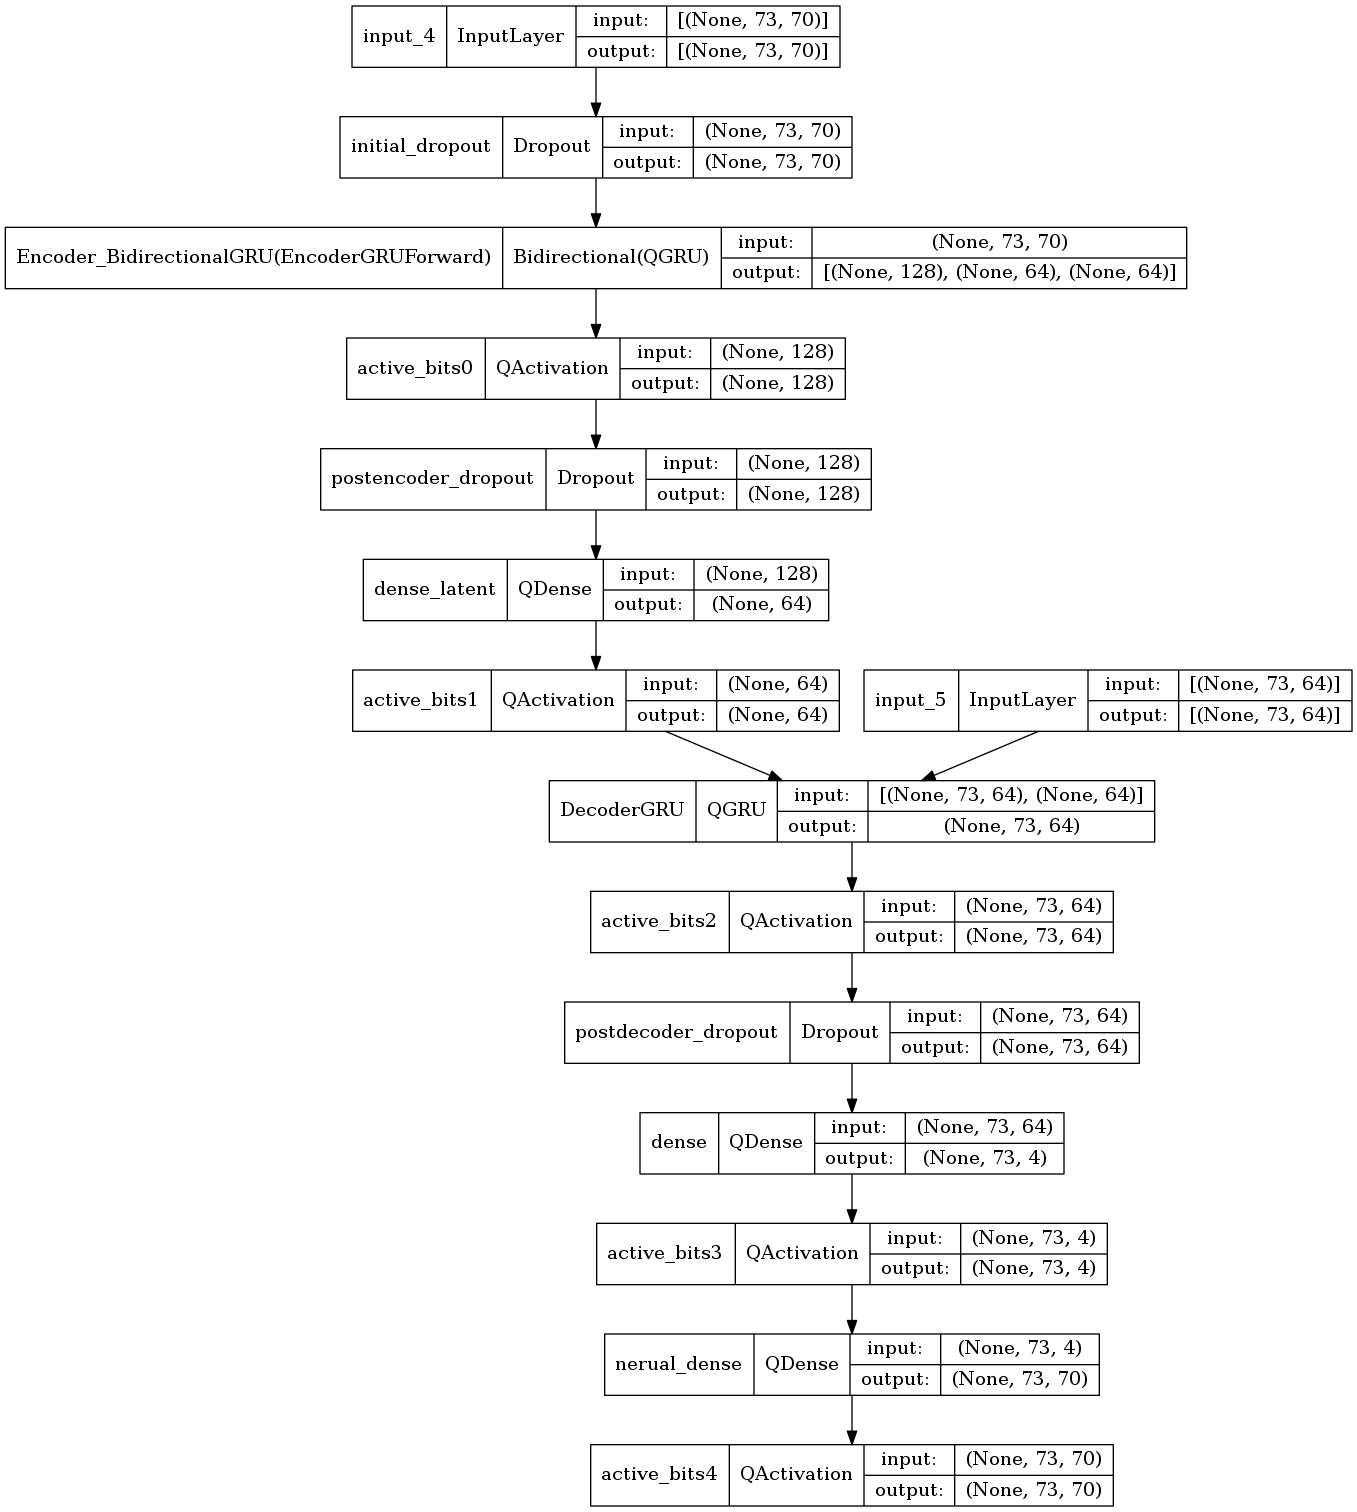

In [36]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True)

# train
## callbacks

In [37]:
csv_logger = tf.keras.callbacks.CSVLogger("lfad16bits_log.csv", separator=",", append=False)
model_check = tf.keras.callbacks.ModelCheckpoint(
    "lfad16bits.h5",
    monitor = "val_loss",
    save_best_only = True,
    save_weights_only= False
)


lfad16bits_callbacks=[csv_logger, model_check]

In [42]:
model.compile(
    loss = poisson_loglike_loss,
    optimizer = optimizer
)

In [43]:
model.fit([x_train, inputs2decoder_train], x_train, batch_size = 8, epochs=200, 
          callbacks = lfad16bits_callbacks,
          validation_data=([x_val, inputs2decoder_val], x_val)
         )

Epoch 1/200
17/17 [==============================] - 79s 5s/step - loss: 22338.8398 - val_loss: 18823.6113
Epoch 2/200
17/17 [==============================] - 80s 5s/step - loss: 18348.9336 - val_loss: 15912.4834
Epoch 3/200
17/17 [==============================] - 79s 5s/step - loss: 16025.1162 - val_loss: 14350.4307
Epoch 4/200
17/17 [==============================] - 79s 5s/step - loss: 14970.2588 - val_loss: 13912.6924
Epoch 5/200
17/17 [==============================] - 78s 5s/step - loss: 14700.3428 - val_loss: 13783.1660
Epoch 6/200
17/17 [==============================] - 78s 5s/step - loss: 14689.7764 - val_loss: 13766.3828
Epoch 7/200
17/17 [==============================] - 78s 5s/step - loss: 14667.2578 - val_loss: 13771.3613
Epoch 8/200
17/17 [==============================] - 79s 5s/step - loss: 14654.4502 - val_loss: 13783.3398
Epoch 9/200
 7/17 [===========>..................] - ETA: 41s - loss: 14508.5342

KeyboardInterrupt: 

# search with keras tuner

In [44]:
import keras_tuner

In [50]:
def build_model(hp):
    act_total_bits = hp.Int("act_total_bits", min_value=2, max_value=16, step=2)
    act_int_bits = hp.Int(" act_int_bits", min_value=0, max_value=act_total_bits-1, step=1)
    qgru_total_bits = hp.Int("qgru_total_bits", min_value=2, max_value=16, step=2)
    qgru_int_bits = hp.Int("qgru_int_bits", min_value=0, max_value=qgru_total_bits-1, step=1)
    qgru_sigmoid_bits = hp.Int("qgru_sigmoid_bits", min_value=2, max_value=16, step=2)
    qgru_tanh_bits = hp.Int("qgru_tanh_bits", min_value=2, max_value=16, step=2)
    #activation = hp.Choice("activation", ["relu", "tanh"])
    #dropout = hp.Boolean("dropout")
    #dropout = hp.Float("drop", min_value=0.05, max_value=0.2, step=0.05)
    
    # call existing model-building code with the hyperparameter values.
    model = create_model(
                        act_total_bits = act_total_bits,
                        act_int_bits = act_int_bits,
                        qgru_total_bits=qgru_total_bits, 
                         qgru_int_bits=qgru_int_bits, 
                         qgru_sigmoid_bits=qgru_sigmoid_bits, 
                         qgru_tanh_bits=qgru_tanh_bits, 
                         drop=dropout, 
                         )
    
    model.compile(
    loss = poisson_loglike_loss,
    optimizer = optimizer
    )
    return model


build_model(keras_tuner.HyperParameters())

In [51]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=100,
    executions_per_trial=2, #reduce results variance
    overwrite=True,
    directory="Q_RAE",
    project_name="Keras_Tuner_Q_RAE",
)


In [52]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
act_total_bits (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 16, 'step': 2, 'sampling': None}
 act_int_bits (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 1, 'step': 1, 'sampling': None}
qgru_total_bits (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 16, 'step': 2, 'sampling': None}
qgru_int_bits (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 1, 'step': 1, 'sampling': None}
qgru_sigmoid_bits (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 16, 'step': 2, 'sampling': None}
qgru_tanh_bits (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 16, 'step': 2, 'sampling': None}


In [54]:
tuner.search([x_train, inputs2decoder_train], x_train, batch_size = 16, epochs=5, validation_data=([x_val, inputs2decoder_val], x_val))


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
14                |?                 |act_total_bits
0                 |?                 | act_int_bits
10                |?                 |qgru_total_bits
1                 |?                 |qgru_int_bits
2                 |?                 |qgru_sigmoid_bits
10                |?                 |qgru_tanh_bits

Epoch 1/5
2/9 [=====>........................] - ETA: 29s - loss: 49767.1875

KeyboardInterrupt: 

In [146]:
tuner.results_summary()

Results summary
Results in Q_RAE/Keras_Tuner_Q_RAE
Showing 10 best trials
Trial summary
Hyperparameters:
qgru_total_bits: 10
qgru_frac_bits: 2
qgru_sigmoid_bits: 14
qgru_tanh_bits: 14
drop: 0.05
Score: 12.014378547668457
Trial summary
Hyperparameters:
qgru_total_bits: 6
qgru_frac_bits: 2
qgru_sigmoid_bits: 12
qgru_tanh_bits: 4
drop: 0.15000000000000002
Score: 13.411163330078125
Trial summary
Hyperparameters:
qgru_total_bits: 10
qgru_frac_bits: 1
qgru_sigmoid_bits: 16
qgru_tanh_bits: 12
drop: 0.15000000000000002
Score: 50.15886688232422
Trial summary
Hyperparameters:
qgru_total_bits: 6
qgru_frac_bits: 1
qgru_sigmoid_bits: 14
qgru_tanh_bits: 12
drop: 0.15000000000000002
Score: 65.70893859863281
Trial summary
Hyperparameters:
qgru_total_bits: 6
qgru_frac_bits: 1
qgru_sigmoid_bits: 10
qgru_tanh_bits: 16
drop: 0.2
Score: 66.4120044708252


In [147]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(2)
# Build the model with the best hp.
model_best = build_model(best_hps[0])

In [148]:
from qkeras.autoqkeras.utils import print_qmodel_summary

In [149]:
print_qmodel_summary(model_best)

active_bits0         quantized_bits(16,5,alpha=1)
dense_mean           u=64 quantized_bits(10,2,0,alpha=1) quantized_bits(10,2,0,alpha=1) 
active_bits1         quantized_bits(16,5,alpha=1)
DecoderGRU           quantized_bits(10,2,0,alpha=1) quantized_bits(10,2,0,alpha=1) quantized_bits(10,2,0,alpha=1) quantized_bits(10,2,0,alpha=1) recurrent act=quantized_sigmoid(14)act=quantized_tanh(14)
active_bits2         quantized_bits(16,5,alpha=1)
dense                u=2 quantized_bits(10,2,0,alpha=1) quantized_bits(10,2,0,alpha=1) 
active_bits3         quantized_bits(16,5,alpha=1)



# Retrain

In [178]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="q_rae.h5",
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [179]:
model_best_history = model_best.fit([x_train, inputs2decoder_train], 
               y_train, 
               batch_size = 16, 
               epochs=100, 
               validation_data=([x_val, inputs2decoder_val], y_val),
               callbacks = model_checkpoint_callback
              
              )


Epoch 1/100
9/9 [==============================] - 42s 5s/step - loss: 440.4053 - val_loss: 428.5734
Epoch 2/100
9/9 [==============================] - 40s 5s/step - loss: 418.9319 - val_loss: 265.6950
Epoch 3/100
9/9 [==============================] - 41s 5s/step - loss: 89.4085 - val_loss: 11.9652
Epoch 4/100
9/9 [==============================] - 41s 5s/step - loss: 16.3485 - val_loss: 14.3313
Epoch 5/100
9/9 [==============================] - 41s 5s/step - loss: 15.7987 - val_loss: 11.9436
Epoch 6/100
9/9 [==============================] - 41s 5s/step - loss: 15.7018 - val_loss: 12.2310
Epoch 7/100
9/9 [==============================] - 41s 5s/step - loss: 15.2562 - val_loss: 11.9041
Epoch 8/100
9/9 [==============================] - 41s 5s/step - loss: 14.8145 - val_loss: 11.8052
Epoch 9/100
9/9 [==============================] - 41s 5s/step - loss: 14.4463 - val_loss: 11.5371
Epoch 10/100
9/9 [==============================] - 41s 5s/step - loss: 14.6204 - val_loss: 11.3720
Epoch

In [180]:
model_best_history2 = model_best.fit([x_train, inputs2decoder_train], 
               y_train, 
               batch_size = 16, 
               epochs=100, 
               validation_data=([x_val, inputs2decoder_val], y_val),
               callbacks = model_checkpoint_callback
              
              )

Epoch 1/100
9/9 [==============================] - 41s 5s/step - loss: 3.3828 - val_loss: 3.6298
Epoch 2/100
9/9 [==============================] - 41s 5s/step - loss: 3.3233 - val_loss: 3.5778
Epoch 3/100
9/9 [==============================] - 40s 4s/step - loss: 3.5023 - val_loss: 3.5587
Epoch 4/100
9/9 [==============================] - 41s 5s/step - loss: 3.3518 - val_loss: 4.0057
Epoch 5/100
9/9 [==============================] - 41s 5s/step - loss: 3.4016 - val_loss: 4.2840
Epoch 6/100
9/9 [==============================] - 40s 5s/step - loss: 3.3546 - val_loss: 3.8781
Epoch 7/100
9/9 [==============================] - 40s 4s/step - loss: 3.2591 - val_loss: 3.6208
Epoch 8/100
9/9 [==============================] - 41s 5s/step - loss: 3.2333 - val_loss: 3.7259
Epoch 9/100
9/9 [==============================] - 40s 5s/step - loss: 3.2370 - val_loss: 3.6391
Epoch 10/100
9/9 [==============================] - 41s 5s/step - loss: 3.1140 - val_loss: 3.7555
Epoch 11/100
9/9 [===========

# Train fp model

In [150]:
from tensorflow.keras.layers import Dense, GRU

In [160]:
def get_fp_model(drop = 0.05, initializer=None, regularizer=None):
    inputLayer =  Input(shape=(73,70))
    x = Dropout(drop, name = 'initial_dropout')(inputLayer)
    x = Bidirectional(GRU(64, time_major=False, 
                            return_state=True, kernel_regularizer=regularizer, 
                            kernel_initializer=initializer), 
                        backward_layer=GRU(64, time_major=False, 
                                           return_state=True, go_backwards=True, 
                                           kernel_regularizer=regularizer, kernel_initializer=initializer), 
                        merge_mode='concat', name = 'Encoder_BidirectionalGRU')(x)[0]
    x = Dropout(drop, name = 'postencoder_dropout')(x)
    x = Dense(64, kernel_regularizer=regularizer, kernel_initializer=initializer, name='dense_mean')(x)

    input_decoder = Input(shape=(73, 64))
    x = GRU(64, return_sequences=True, 
          time_major=False, kernel_initializer=initializer, 
          kernel_regularizer=regularizer, name='decoder_GRU')(input_decoder, initial_state = x)
    x = Dropout(drop, name = 'postdecoder_dropout')(x)
    out = Dense(2, use_bias = False, kernel_regularizer=regularizer, kernel_initializer=initializer, name='dense')(x)

    model = Model(inputs = [inputLayer,input_decoder], outputs = out)
    model.compile(
        optimizer="adam", loss="mean_squared_error",
    )
    return model

In [175]:
fp_model = get_fp_model(0.05)

In [172]:
fp_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['input_12[0][0]']               
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                            

In [176]:
fp_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="fp_rae.h5",
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [177]:
fp_model_history = fp_model.fit([x_train, inputs2decoder_train], 
               y_train, 
               batch_size = 16, 
               epochs=100, 
               validation_data=([x_val, inputs2decoder_val], y_val),
               callbacks = fp_model_checkpoint_callback
              
              )


Epoch 1/100
9/9 [==============================] - 1s 62ms/step - loss: 440.2311 - val_loss: 426.9939
Epoch 2/100
9/9 [==============================] - 0s 57ms/step - loss: 426.4987 - val_loss: 396.0594
Epoch 3/100
9/9 [==============================] - 1s 61ms/step - loss: 343.5681 - val_loss: 188.4115
Epoch 4/100
9/9 [==============================] - 0s 55ms/step - loss: 94.2040 - val_loss: 51.0569
Epoch 5/100
9/9 [==============================] - 0s 52ms/step - loss: 28.9267 - val_loss: 15.4101
Epoch 6/100
9/9 [==============================] - 1s 59ms/step - loss: 21.1428 - val_loss: 14.0467
Epoch 7/100
9/9 [==============================] - 0s 55ms/step - loss: 15.5409 - val_loss: 12.3932
Epoch 8/100
9/9 [==============================] - 0s 35ms/step - loss: 15.9774 - val_loss: 12.4320
Epoch 9/100
9/9 [==============================] - 0s 52ms/step - loss: 15.3052 - val_loss: 11.6466
Epoch 10/100
9/9 [==============================] - 0s 51ms/step - loss: 15.0821 - val_loss: 1

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Flatten, GRU, Activation, Embedding, Bidirectional, Flatten, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import Model
import hls4ml
import numpy as np




initializer = tf.keras.initializers.VarianceScaling(distribution='normal')
regularizer = tf.keras.regularizers.L2(l=1)
inputs2model = test_neural_data # 17, 73, 70
inputDim = 136
inputs2decoder = tf.stack([tf.zeros_like(inputs2model)[:, :, -1]
            for i in range(64)], axis=-1)

# if isinstance(inputs2model, np.ndarray):
#   print("inputs2model IS numpy array")
# else:
#   print("inputs2model IS NOT numpy array")

# if isinstance(inputs2decoder, np.ndarray):
#   print("inputs2decoder IS numpy array")
# else:
#   print("inputs2decoder IS NOT numpy array")

# if isinstance(inputs2decoder, list):
#   print("inputs2decoder IS list")
# else:
#   print("inputs2decoder IS NOT list")

inputs2decoder_np = np.array(inputs2decoder)

if isinstance(inputs2decoder, np.ndarray):
  print("inputs2decoder IS numpy array")
else:
  print("inputs2decoder IS NOT numpy array")

# inputs2decoder = np.zeros((17,73,64))
def create_model(inputs2model, inputs2decoder, initializer, regularizer):
  
  inputLayer =  Input(shape=inputs2model[0].shape)
  x = Dropout(0.05, name = 'initial_dropout')(inputLayer)
  x = Bidirectional(GRU(64, time_major=False, 
                        return_state=True, kernel_regularizer=regularizer, 
                        kernel_initializer=initializer), 
                    backward_layer=GRU(64, time_major=False, 
                                       return_state=True, go_backwards=True, 
                                       kernel_regularizer=regularizer, kernel_initializer=initializer), 
                    merge_mode='concat', name = 'Encoder_BidirectionalGRU')(x)[0]
  x = Dropout(0.05, name = 'postencoder_dropout')(x)
  x = Dense(64, kernel_regularizer=regularizer, kernel_initializer=initializer, name='dense_mean')(x)
  input_decoder = Input(shape=inputs2decoder[0].shape)
  x = GRU(64, return_sequences=True, 
          time_major=False, kernel_initializer=initializer, 
          kernel_regularizer=regularizer, name='decoder_GRU')(input_decoder, initial_state = x)
  x = Dropout(0.05, name = 'postdecoder_dropout')(x)
  z = Dense(4, use_bias = False, kernel_regularizer=regularizer, kernel_initializer=initializer, name='dense')(x)
  log_f = Dense(70, kernel_regularizer=regularizer, kernel_initializer=initializer, name='nerual_dense')(z)
  # z = Flatten()(z)
  # temp_1 = Dense(5,name='dense_temp1')(z)
  # log_f = Flatten()(log_f)
  # temp_2 = Dense(5,name='dense_temp2')(log_f)
  out = Concatenate()([z,log_f])

 # return Model(inputs = [inputLayer,input_decoder], outputs =[z, log_f])
  return Model(inputs = [inputLayer,input_decoder], outputs =out)

LFADs_keras = create_model(inputs2model,inputs2decoder, initializer, regularizer)
# LFADs_keras.summary()
LFADs_keras.compile()

LFADs = tf.keras.models.load_model("/home/xiaohan/HLS4ML_side_branch/hls4ml/test_LFADs/3_3.h5")
# LFADs.summary()

LFADs_keras.layers[2].set_weights(LFADs.layers[2].get_weights())
LFADs_keras.layers[5].set_weights(LFADs.layers[5].get_weights())
LFADs_keras.layers[6].set_weights(LFADs.layers[6].get_weights())
LFADs_keras.layers[8].set_weights(LFADs.layers[8].get_weights())
LFADs_keras.layers[9].set_weights(LFADs.layers[9].get_weights())

lfads_out = LFADs_keras.predict([inputs2model, inputs2decoder_np])
print("lfads_out prediction by keras is:")
print(lfads_out.shape)

config = hls4ml.utils.config_from_keras_model(LFADs_keras, granularity='model', default_precision='ap_fixed<32,16>')
print("-----------------------------------")
print("Configuration")
'''plotting.print_dict(config)'''
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(LFADs_keras,
                                                       hls_config=config,
                                                       output_dir='/home/xiaohan/HLS4ML_side_branch/hls4ml/test_LFADs',
                                                       part='xc7v2000tflg1925-2')
print("done")
hls_model.compile()
hls_out = hls_model.predict([inputs2model, inputs2decoder_np])
hls_out = np.reshape(hls_out, (17,73,74))
print(hls_out)
#hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)
# hls_model.build(csim=False)
hls_out_z = hls_out[:,:,:4]
hls_out_log_f = hls_out[:,:,4:]
print(hls_out_z.shape)
print(hls_out_log_f.shape)
print("z", hls_out_z)
print("log_f",hls_out_log_f)
np.savetxt("/home/xiaohan/HLS4ML_side_branch/hls4ml/test_LFADs/hls_out_z_32_16.txt", hls_out_z.reshape((-1, hls_out_z.shape[-1])))
np.savetxt("/home/xiaohan/HLS4ML_side_branch/hls4ml/test_LFADs/hls_out_log_f_32_16.txt", hls_out_log_f.reshape((-1, hls_out_log_f.shape[-1])))

In [ ]:
np.random.seed(3)
input_shape = (73, 70)  # Shape of the 'inputs' tensor 
# input_shape = (5, 2) # for testing
batch_size = 136  # Batch size
inputs_data = np.random.rand(batch_size, *input_shape)
# print(inputs_data)
load_test_data = np.loadtxt("/home/xiaohan/HLS4ML_side_branch/hls4ml/test_LFADs/test_nerual_data.txt")
test_neural_data = load_test_data.reshape((17,73,70))
print(test_neural_data.shape)

In [6]:


# center behaviour at zero, using first time step (not strictly required)
b_mean = np.mean(np.vstack((behavioural_data, test_behavioural_data, valid_behavioural_data))[:,0,:],axis=0)
for i in range(2):
    behavioural_data[:,:,i] = behavioural_data[:,:,i]-b_mean[i]
    valid_behavioural_data[:,:,i] = valid_behavioural_data[:,:,i]-b_mean[i]
    test_behavioural_data[:,:,i] = test_behavioural_data[:,:,i]-b_mean[i]

# for plotting
d_all = np.concatenate((dataset['train_target_direction'], dataset['test_target_direction'], dataset['valid_target_direction']))
d = dataset['train_target_direction']
direction_index_train = np.array([sorted(set(d_all)).index(i) for i in d])
d = dataset['test_target_direction']
direction_index_test = np.array([sorted(set(d_all)).index(i) for i in d])
direction_index_all = np.concatenate((direction_index_test, direction_index_train))

In [7]:
behavioural_data.max()

8.915750104329124

In [7]:
# model parameters

# l2 regulariser for the recurrent decoder weights
l2_reg = .1
initial_neural_weight = 1.0 # weight of neural nll
initial_behaviour_weight = .2 # weight of behaviour loss
lambda_q = 100.0
update_rate = .0005
dropout = .15
seed = 0
GRU_pre_activation = False
var_min = 0.0001
prior_variance = 1

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-2,
    beta_1=0.9, 
    beta_2=0.999,
    epsilon=1e-08)

layers_settings=defaultdict(lambda: dict(
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1.0, mode='fan_in', distribution='normal'),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)
))

layers_settings['encoder'].update(dict(var_min=var_min, var_trainable=True))
layers_settings['decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))    

# for Qkeras
# 8 bits

In [8]:
layers_settings['quantizer'] = "quantized_bits(8,0,1,alpha=1.0)"

In [9]:
T = datetime.today().strftime("%y_%m_%d_%X")

logdir = os.path.join( spike_data_dir, 'lfads_log_l2_reg_'+str(l2_reg)+'_'+T)
modeldir = os.path.join( spike_data_dir, 'lfads_model_l2_reg_'+str(l2_reg)+'_'+T)

In [11]:
T0 = datetime.now()

model, history, x_train, y_train, (x_test, y_test) = Runtime.train(
    model_type=ModelType.LFADS,
    adaptive_lr=dict(factor=0.95, patience=10, min_lr=1e-5),
    model_settings=dict(
        factors=4,
        encoded_dim=64,
        max_grad_norm=200,
        dropout=dropout,
        prior_variance=prior_variance,
        GRU_pre_activation=GRU_pre_activation, #NEW
        timestep=settings['step'],
        seed=seed
    ),
    layers_settings=layers_settings,
    optimizer=optimizer, 
    epochs=1, 
    logdir=logdir,
    train_dataset=(neural_data, behavioural_data), 
    val_dataset=(valid_neural_data, valid_behavioural_data),
    adaptive_weights=AdaptiveWeights(
        initial=[initial_neural_weight, initial_behaviour_weight, .0, .0, lambda_q, .0], #changed
        update_start=[0, 0, 0, 1000, 1000, 0],
        update_rate=[0., 0., update_rate, update_rate, 0.0, update_rate],
        min_weight=[initial_neural_weight, initial_behaviour_weight, 0.0, 0.0, lambda_q, 0.0],#changed
        max_weight=[initial_neural_weight, initial_behaviour_weight, 1.0, 1.0, lambda_q, 1.0],#changed
    ),
    batch_size=16,
    verbose=2 # set to 2 to see the losses during training
)

#model.save(modeldir)

print('Training took '+str(datetime.now()-T0))

no sampling
no sampling
no sampling
no sampling
no sampling
no sampling
no sampling
no sampling
no sampling
no sampling
no sampling
9/9 - 31s - loss: 3026.0627 - loss/loglike: 3023.4573 - loss/kldiv: 13.0235 - loss/reg: 60.5014 - loss/reconstruction: 3023.4573 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0020 - learning_rate: 0.0100 - val_loss: 2750.0479 - val_loss/loglike: 2749.2937 - val_loss/kldiv: 3.7715 - val_loss/reconstruction: 2749.2937 - lr: 0.0100 - 31s/epoch - 3s/step
Training took 0:00:31.456461


In [12]:
neural_data.shape

(136, 73, 70)

In [13]:
decodergru = model.layers[7]

In [14]:
decodergru.__dict__

{'_self_setattr_tracking': True,
 '_obj_reference_counts_dict': ObjectIdentityDictionary({<_ObjectIdentityWrapper wrapping False>: 4, <_ObjectIdentityWrapper wrapping <qkeras.qrecurrent.QGRUCell object at 0x7f351c59efd0>>: 1, <_ObjectIdentityWrapper wrapping True>: 2, <_ObjectIdentityWrapper wrapping 0>: 1, <_ObjectIdentityWrapper wrapping ListWrapper([InputSpec(shape=(1, 64), ndim=2)])>: 1}),
 'zero_output_for_mask': False,
 '_instrumented_keras_api': True,
 '_instrumented_keras_layer_class': True,
 '_instrumented_keras_model_class': False,
 '_trainable': True,
 '_input_spec': [InputSpec(shape=(None, None, 64), ndim=3)],
 '_build_input_shape': TensorShape([None, 73, 64]),
 '_saved_model_inputs_spec': TensorSpec(shape=(None, 73, 64), dtype=tf.float32, name=None),
 '_saved_model_arg_spec': ([TensorSpec(shape=(None, 73, 64), dtype=tf.float32, name=None),
   [TensorSpec(shape=(None, 64), dtype=tf.float32, name=None)]],
  {}),
 '_name': 'DecoderGRU',
 '_trainable_weights': [],
 '_non_train

In [15]:
decodergru.cell.__dict__

{'_self_setattr_tracking': True,
 '_obj_reference_counts_dict': ObjectIdentityDictionary({<_ObjectIdentityWrapper wrapping 'quantized_bits(8,0,1,alpha=1.0)'>: 4, <_ObjectIdentityWrapper wrapping <qkeras.quantizers.quantized_bits object at 0x7f351c59ea30>>: 1, <_ObjectIdentityWrapper wrapping <qkeras.quantizers.quantized_bits object at 0x7f351c59ed60>>: 1, <_ObjectIdentityWrapper wrapping <qkeras.quantizers.quantized_bits object at 0x7f353c619160>>: 1, <_ObjectIdentityWrapper wrapping <qkeras.quantizers.quantized_bits object at 0x7f351c601b50>>: 1, <_ObjectIdentityWrapper wrapping ListWrapper([<qkeras.quantizers.quantized_bits object at 0x7f351c59ea30>, <qkeras.quantizers.quantized_bits object at 0x7f351c59ed60>, <qkeras.quantizers.quantized_bits object at 0x7f353c619160>, <qkeras.quantizers.quantized_bits object at 0x7f351c601b50>])>: 1, <_ObjectIdentityWrapper wrapping True>: 3, <_ObjectIdentityWrapper wrapping 64>: 3, <_ObjectIdentityWrapper wrapping <function hard_tanh at 0x7f35444f

In [16]:
decodergru.cell.activation

<function qkeras.quantizers.hard_tanh(x)>

In [17]:
decodergru.cell.recurrent_quantizer

'quantized_bits(8,0,1,alpha=1.0)'

In [18]:
model.summary()

Model: "lfads_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 EncoderRNN (Bidirectional)  multiple                  51840     
                                                                 
 dropout_4 (Dropout)         multiple                  0         
                                                                 
 dropout_5 (Dropout)         multiple                  0         
                                                                 
 DenseMean (QDense)          multiple                  8256      
                                                                 
 DenseLogVar (QDense)        multiple                  8256      
                                                                 
 activation_1 (Activation)   multiple                  0 (u

# Rebuild 

In [31]:
from qkeras import QGRU, QDense
from tensorflow.keras.layers import Bidirectional, Dropout, RNN, Input

In [32]:
tensor_in = Input(shape = neural_data.shape[1:])

In [ ]:
x = tensor_in

In [33]:
def create_model(inputs2model, inputs2decoder, initializer, regularizer):
  
  inputLayer =  Input(shape=inputs2model[0].shape)
  x = Dropout(0.05, name = 'initial_dropout')(inputLayer)
  x = Bidirectional(GRU(64, time_major=False, 
                        return_state=True, kernel_regularizer=regularizer, 
                        kernel_initializer=initializer), 
                    backward_layer=GRU(64, time_major=False, 
                                       return_state=True, go_backwards=True, 
                                       kernel_regularizer=regularizer, kernel_initializer=initializer), 
                    merge_mode='concat', name = 'Encoder_BidirectionalGRU')(x)[0]
  x = Dropout(0.05, name = 'postencoder_dropout')(x)
  x = Dense(64, kernel_regularizer=regularizer, kernel_initializer=initializer, name='dense_mean')(x)
  input_decoder = Input(shape=inputs2decoder[0].shape)
  x = GRU(64, return_sequences=True, 
          time_major=False, kernel_initializer=initializer, 
          kernel_regularizer=regularizer, name='decoder_GRU')(input_decoder, initial_state = x)
  x = Dropout(0.05, name = 'postdecoder_dropout')(x)
  z = Dense(4, use_bias = False, kernel_regularizer=regularizer, kernel_initializer=initializer, name='dense')(x)
  log_f = Dense(70, kernel_regularizer=regularizer, kernel_initializer=initializer, name='nerual_dense')(z)
  # z = Flatten()(z)
  # temp_1 = Dense(5,name='dense_temp1')(z)
  # log_f = Flatten()(log_f)
  # temp_2 = Dense(5,name='dense_temp2')(log_f)
  out = Concatenate()([z,log_f])

 # return Model(inputs = [inputLayer,input_decoder], outputs =[z, log_f])
  return Model(inputs = [inputLayer,input_decoder], outputs =out)

LFADs_keras = create_model(inputs2model,inputs2decoder, initializer, regularizer)

# Latent space

## Training data

In [18]:
log_f, (g0, mean, logvar), z =  model(neural_data.astype('float'), training=False)

no sampling


In [19]:
z.shape

TensorShape([136, 73, 4])

In [20]:
behavioural_data.shape

(136, 73, 2)

Text(0.5, 1.0, 'Factors')

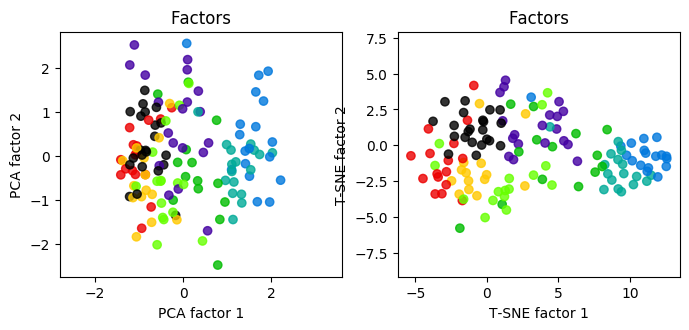

In [21]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(8,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(mean)
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('PCA factor 1')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(mean)
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('T-SNE factor 1')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


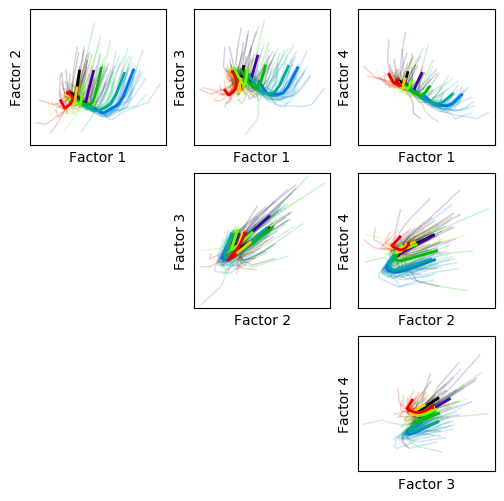

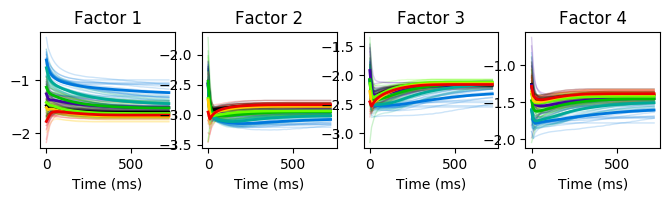

In [22]:
# latent factors
plt.figure(figsize=(6,6))
plot_all_2factors(z, direction_index_train)
plt.figure(figsize=(8,1.5))
plot_all_1factors(z, direction_index_train)


In [23]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = X
yt = y

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]

0.6539638713725283


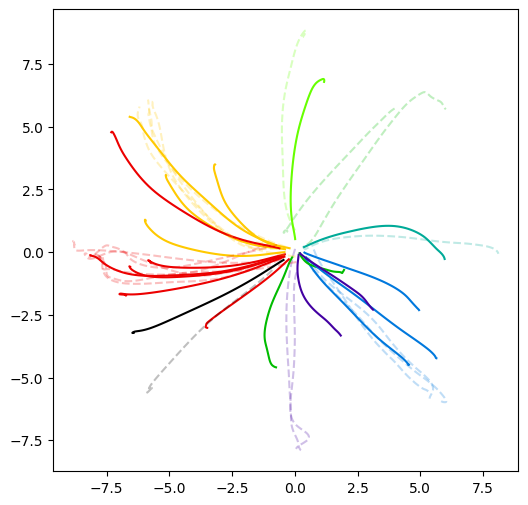

In [24]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b, behavioural_data, direction_index_train, num=20)

In [25]:
Xt = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
yt = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 65.396%


## Test data

In [26]:
log_f_t, (g0_t, mean_t, logvar_t), z_t = \
    model(test_neural_data.astype('float'), training=False)

no sampling


Text(0.5, 1.0, 'Factors')

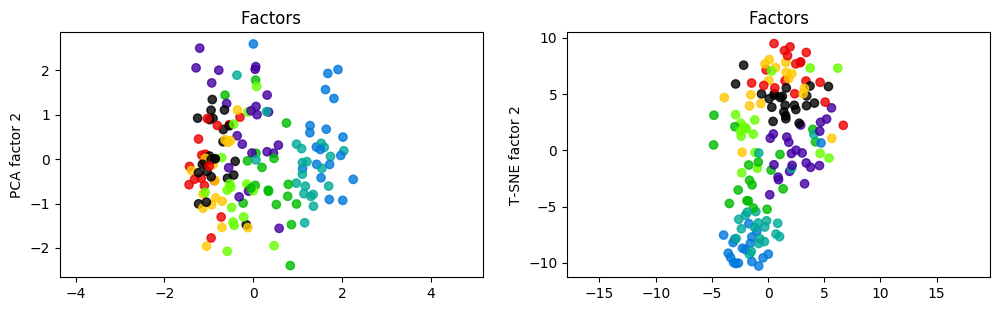

In [27]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(12,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


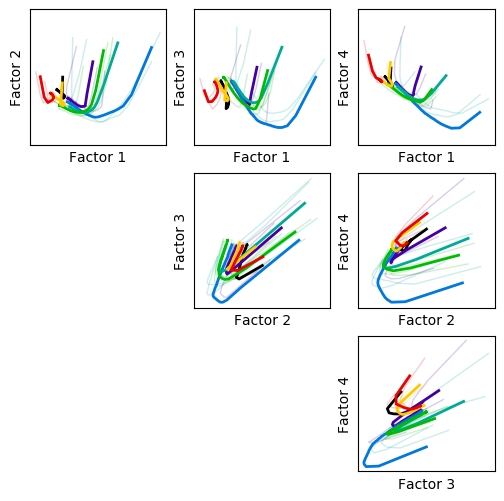

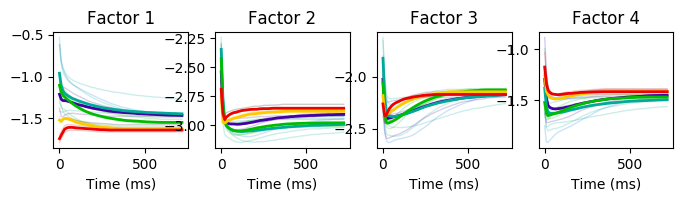

In [28]:
# relevant factors
plt.figure(figsize=(6,6))
plot_all_2factors(z_t, direction_index_test)
# relevant factors
plt.figure(figsize=(8,1.5))
plot_all_1factors(z_t, direction_index_test)


In [29]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = np.transpose(z_t.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b_t = np.zeros_like(test_behavioural_data)
b_t[:,:,0] = beh_fit[:,:test_behavioural_data.shape[1]]
b_t[:,:,1] = beh_fit[:,test_behavioural_data.shape[1]:]

0.6641319423076898


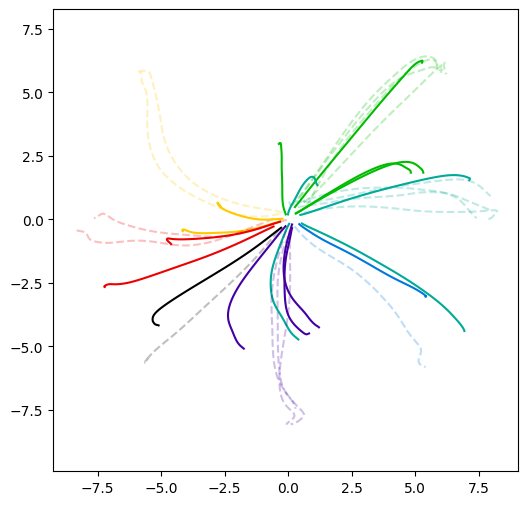

In [30]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b_t, test_behavioural_data, direction_index_test, num=100)
# plot_behaviour(b, behavioural_data, direction_index_train)

In [31]:
Xt = np.transpose(b_t, (0,2,1)).reshape((b_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 66.413%


# Trial-averaged firing rates and predictions
Computed from test+train data for better averages

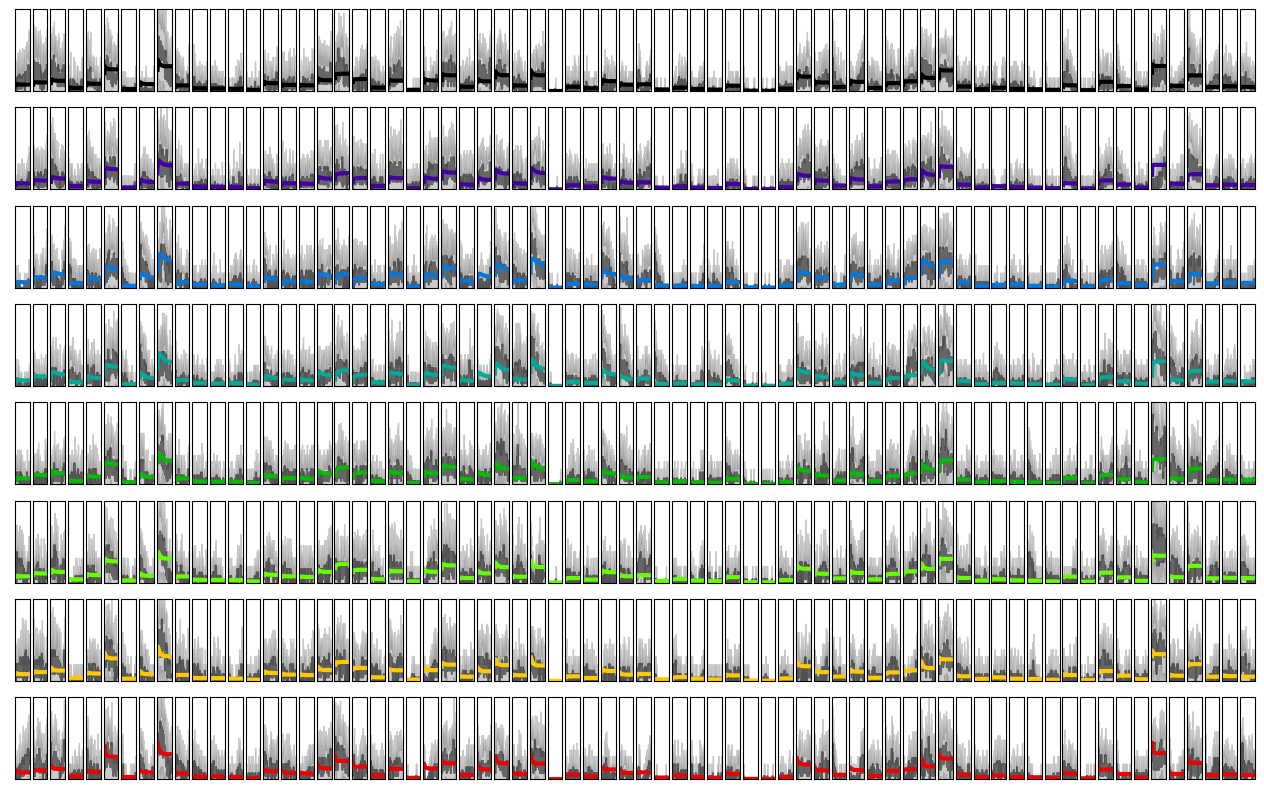

In [32]:
from sklearn.metrics import mean_squared_error
fig = plt.figure(figsize=(16,10))
colors = plt.cm.nipy_spectral(np.arange(8)/8)
a = []
for i in range(8):
    data = np.vstack((test_neural_data, neural_data))[direction_index_all==i,:,:]

    for i_n,n in enumerate(range(0,70)):
        ax = fig.add_subplot(8, 70, i*70+i_n+1)
        pred = np.vstack((np.exp(log_f_t)*settings['step'], np.exp(log_f)*settings['step']))[np.array(direction_index_all)==i,:,n]
        x = np.arange(data.shape[1])
        ax.plot(x,np.mean(data,axis=0)[:,n],'k',alpha=0.5);
        data_mean = np.mean(data,axis=0)
        data_mean_test = np.mean(data,axis=0)[:,n]
#         print("n",n)
#         print(pred.shape)
#         print(data_mean_test.shape)
        
        ax.fill_between(x,np.mean(data,axis=0)[:,n]-np.std(data,axis=0)[:,n], np.mean(data,axis=0)[:,n]+np.std(data,axis=0)[:,n], alpha=0.2, color='k');
        ax.plot(x,np.mean(pred,axis=0),lw=3, color=colors[i]);
        pred_test = np.mean(pred,axis=0)
#         print(pred_test.shape)

        ax.set_xticks(())
        ax.set_yticks(())
        plt.ylim(0,1.5)
        
        data4mse = data_mean_test
        pred4mse = pred_test
        diff = mean_squared_error(data4mse,pred4mse)
        a.append(diff)
        


In [33]:
print(sum(a) / len(a))
print(max(a))
print(min(a))
print(log_f.shape)

0.010419876171068312
0.08689772665750417
1.0964972088578873e-06
(136, 73, 70)


In [34]:
d_all = dataset['test_target_direction']

d = dataset['test_target_direction']
direction_index_test = np.array([sorted(set(d_all)).index(i) for i in d])
direction_index_all =direction_index_test
print(direction_index_all.shape)

(17,)
